In [13]:
%load_ext autoreload
%autoreload 2
import random
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_NQueens, plot_evolution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Local Search: Genetic Algorithm

## 1.Genrating Phrases

In this section we consider a toy problem: generating a target phrases (e.g. "genetic algorithm") from an initial polupation of random strings. Assume the length of the target is known.

Problem Formulation: 

1. Direct Representation: just strings.
2. Exponential Search Space: $m^l$ where $m$ is the size of the alphabet (set of characters in our interest) and $l$ is the length of the string.

Now that we want to solve it with GA:
1. Chromesome: directly use the string itself.
2. Fitness: how match/close an individual is to the target.
3. Mating: combine two strings in someway to generate a new one.

The following cells will walk you through this problem to show the basic idea of GA

In [14]:
# setting up the problem
target = 'Genetic Algorithm'
u_case = [chr(x) for x in range(65, 91)]
l_case = [chr(x) for x in range(97, 123)]
gene_pool = u_case + l_case + [' '] # all English chracters and white space

def init_population(pop_size, gene_pool, state_length):
    """
    Randomly initialize a population for genetic algorithm
        pop_size  :  Number of individuals in population
        gene_pool   :  List of possible values for individuals
        state_length:  The length of each individual
    """

    population = []
    for _ in range(pop_size):
        new_individual = "".join(random.choices(gene_pool, k=state_length))
        population.append(new_individual)

    return population

# test
init_pop = init_population(10, gene_pool, len(target))
init_pop

['ftAm UbtiTPejLkTQ',
 'V ZNDWdqKfvkKabUD',
 'xQKVaVkVtKImlaIfQ',
 'jQHroAfjMothuE rq',
 'byyJwzQbzqIIVWjIK',
 'JqfScTrYnWjyImYfq',
 'KreSxUgBTTkVPKFgB',
 'DfJWN adcVASHbHHg',
 'iEBQpWgDfypOHv j ',
 ' QgId yQF rmOfaVo']

In [15]:
def fitness_fn(sample):
    # TODO: evaluate how close *sample* is to the target
    cnt = 0
    for i in range(len(sample)):
        if target[i] == sample[i]:
            cnt += 1
    return cnt

# test
for i in range(10):
    print(fitness_fn(init_pop[i]), end=" ")

0 0 0 0 0 0 0 0 0 0 

In [16]:
def select(r, population, fitness_fn):
    """
    TODO: select *r* samples from *population*
    the simplest choice is to sample from *population* with each individual weighted by its fitness
    """
    new_population = sorted(population, key=lambda x: fitness_fn(x), reverse=True)
    return new_population[:r]

# test
parents = select(2, init_pop, fitness_fn)
parents

['ftAm UbtiTPejLkTQ', 'V ZNDWdqKfvkKabUD']

In [17]:
def recombine(x, y):
    """
    TODO: combine two parents to produce an offspring
    """
    new = []
    for i in range(len(x)):
        r = random.randint(1, 100)
        new.append(x[i] if r % 2 == 0 else y[i])
    return "".join(new)
    

def mutate(x, gene_pool, pmut):
    """
    apply mutation to *x* by randomly replacing one of its gene from *gene_pool*
    """
    if random.uniform(0, 1) >= pmut:
        return x

    n = len(x)
    g = len(gene_pool)
    c = random.randrange(0, n)
    r = random.randrange(0, g)

    new_gene = gene_pool[r]
    return x[:c] + new_gene + x[c + 1:]

# test
child = mutate(recombine(*parents), gene_pool, 0.1)
child

'ftZNDWdtKfPkKLbUD'

In [18]:
# now refactor things into a *Problem* abstraction
# you can directly reuse what you have implemented above
from abc import ABC, abstractmethod

class GAProblem(ABC):
    @abstractmethod
    def init_population(self, pop_size): pass

    @abstractmethod
    def fitness(self, sample): pass

    @abstractmethod
    def reproduce(self, population): pass

    @abstractmethod
    def replacement(self, old, new): pass

class PhraseGeneration(GAProblem):
    def __init__(self, target, alphabet):
        self.target = target
        self.alphabet = alphabet
        self.pop_size = None

    def init_population(self, pop_size):
        # raise NotImplementedError()
        choice = lambda: "".join(random.choices(self.alphabet, k = len(self.target)))
        population = [choice() for _ in range(pop_size)]
        self.pop_size = pop_size
        return population


    def fitness(self, sample):
        # TODO: evaluate how close *sample* is to the target
        cnt = 0
        for i in range(len(self.target)):
            if self.target[i] == sample[i]:
                cnt += 1
        return cnt
    
    def reproduce(self, population, mutation_rate):
        """
        TODO: generate the next generation of population
        hint: make a new individual with 
        mutate(recombine(*select(2, population, fitness_fn)), gene_pool, pmut)
        """
        child = lambda: self.mutate(self.recombine(*self.select(2, population)), mutation_rate)
        return [child() for _ in range(len(population) // 2)]
    
    def replacement(self, old, new):
        """
        You can use your own strategy, for example retain some solutions from the old population
        """
        return sorted(old + new, key=lambda x: self.fitness(x), reverse=True)[:len(old)]
    
    def mutate(self, x, pmut):
        """
        apply mutation to *x* by randomly replacing one of its gene from *gene_pool*
        """
        if random.uniform(0, 1) >= pmut:
            return x

        n = len(x)
        g = len(self.alphabet)
        c = random.randrange(0, n)
        r = random.randrange(0, g)

        new_gene = self.alphabet[r]
        return x[:c] + new_gene + x[c + 1:]
    
    def recombine(self, x, y):
        """
        combine two parents to produce an offspring
        """
        new = []
        for i in range(len(x)):
            r = random.randint(1, 10)
            new.append(x[i] if r % 2 == 0 else y[i])
        return "".join(new)

    def select(self, r, population):
        """
        TODO: select *r* samples from *population*
        the simplest choice is to sample from *population* with each individual weighted by its fitness
        """
        new_population = sorted(population, key=lambda x: self.fitness(x), reverse=True)
        return new_population[:r]

def genetic_algorithm(
        problem: PhraseGeneration, 
        ngen, n_init_size, mutation_rate, 
        log_intervel=50
    ):

    population = problem.init_population(n_init_size)
    best = max(population, key=problem.fitness)
    history = [(0, list(map(problem.fitness, population)))]

    for gen in range(ngen):
        next_gen    = problem.reproduce(population, mutation_rate)
        population  = problem.replacement(population, next_gen)

        if gen % log_intervel == 0:
            current_best = max(population, key=problem.fitness)
            if problem.fitness(current_best) > problem.fitness(best): best = current_best
            print(f"Generation: {gen}/{ngen},\tBest: {best},\tFitness={problem.fitness(best)}")         
            history.append((gen, list(map(problem.fitness, population))))

            if current_best == problem.target:
                break
    
    history.append((ngen-1, list(map(problem.fitness, population))))
    return best, history

In [25]:
u_case = [chr(x) for x in range(65, 91)]
l_case = [chr(x) for x in range(97, 123)]
num = [chr(x) for x in range(48, 58)]
gene_pool = u_case + l_case + num + [' ']

# now set up the parameters
ngen = 1200
max_population = 100
mutation_rate = 0.5

sid = 12110817 #TODO:  replace this with your own sid
target = f"Genetic Algorithm by {sid}" 
alphabet = gene_pool # TODO: fix this: what is the search space now?

problem = PhraseGeneration(target, alphabet)

# and run it
def test():
    solution, history = genetic_algorithm(problem, ngen, max_population, mutation_rate)
    print(solution)

import cProfile
cProfile.run("test()")


Generation: 0/1200,	Best: Xx5etnrqzDAHrp4kdlHyFigxO0Pbm,	Fitness=5
Generation: 50/1200,	Best: Qe6eti1qAPgori4km HyF1gIO0Pbm,	Fitness=14
Generation: 100/1200,	Best: Genetic APgori4km byF1g110Pbm,	Fitness=21
Generation: 150/1200,	Best: Genetic APgori4hm by 12110Pb7,	Fitness=25
Generation: 200/1200,	Best: Genetic Algorithm by 12110Pb7,	Fitness=27
Generation: 250/1200,	Best: Genetic Algorithm by 121108b7,	Fitness=28
Generation: 300/1200,	Best: Genetic Algorithm by 12110817,	Fitness=29
Genetic Algorithm by 12110817
         9108432 function calls in 10.073 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.002    0.002 3620778933.py:24(init_population)
      100    0.000    0.000    0.002    0.000 3620778933.py:26(<lambda>)
        1    0.000    0.000    0.002    0.002 3620778933.py:27(<listcomp>)
  1551871    7.031    0.000    7.183    0.000 3620778933.py:32(fitness)
      301    0.002    0.000    

## 2. N-Queens Problem

It is possible to solve the N-Queens problem with slight modifications.

For the problem:

1. Direct Representation: placement of queens.
2. Search Space: $n^n$, if we don't use any constraints.

To use GA:

Actually a new fitness function is the minimum modification you need for this problem.

Others are alomost the same as the previous problem.

In [20]:


class NQueensProblem(GAProblem):
    def __init__(self, n):
        self.n = n
        self.max_fitness = n*(n-1)//2 # max number if non-attacking pairs
        self.alphabet = [i for i in range(self.n)]
        self.false_board = np.zeros((self.n, self.n), dtype=bool)


    def init_population(self, pop_size):
        # TODO:almost the same as the previous problem.
        return [random.choices(self.alphabet, k=self.n) for _ in range(pop_size)]
    

    def fitness(self, queens):
        """
        TODO hint: count the non-attacking pairs
        """
        board = np.copy(self.false_board)
        queen_pos = np.array([(i, queens[i]) for i in range(self.n)])
        board[queen_pos[:, 0], queen_pos[:, 1]] = True

        sum = 0
        for pos in queen_pos:
            attack_board = self.get_attack_board(pos)
            sum += (board & attack_board).sum() - 1
        
        return self.max_fitness - sum
            

    def get_attack_board(self, move):
        def my_range(start, end):
            if start <= end:
                return range(start, end + 1)
            else:
                return range(start, end - 1, -1)
    
        attack_board = np.copy(self.false_board)
        attack_board[:, move[1]] = attack_board[move[0], :] = True
        i, j = move
        tmp = min(self.n - i - 1, j)
        start = (i + tmp, j - tmp)
        tmp = min(i, self.n - j - 1)
        end = (i - tmp,  j + tmp)
        rows = my_range(start[0], end[0])
        cols = my_range(start[1], end[1])
        attack_board[rows, cols] = True

        tmp = min(i, j)
        start = (i - tmp, j - tmp)
        tmp = min(self.n - i - 1, self.n - j - 1)
        end = (i + tmp, j + tmp)
        rows = my_range(start[0], end[0])
        cols = my_range(start[1], end[1])
        attack_board[rows, cols] = True
        
        return attack_board

        

    def reproduce(self, population, mutation_rate):
        """
        TODO: generate the next generation of population
        hint: make a new individual with 
        mutate(recombine(*select(2, population, fitness_fn)), gene_pool, pmut)
        """
        child = lambda: self.mutate(self.recombine(*self.select(2, population)), mutation_rate)
        return [child() for _ in range(len(population) // 10)]
    
    def replacement(self, old, new):
        """
        You can use your own strategy, for example retain some solutions from the old population
        """
        return sorted(old + new, key=lambda x: self.fitness(x), reverse=True)[:len(old)]
    
    def mutate(self, x, pmut):
        """
        apply mutation to *x* by randomly replacing one of its gene from *gene_pool*
        """
        if random.uniform(0, 1) >= pmut:
            return x

        n = len(x)
        g = len(self.alphabet)
        c = random.randrange(0, n)
        r = random.randrange(0, g)

        new_gene = self.alphabet[r]
        return x[:c] + [new_gene] + x[c + 1:]
    
    def recombine(self, x, y):
        """
        combine two parents to produce an offspring
        """
        new = []
        for i in range(len(x)):
            r = random.randint(1, 10)
            new.append(x[i] if r % 2 == 0 else y[i])
        return new

    def select(self, r, population):
        """
        TODO: select *r* samples from *population*
        the simplest choice is to sample from *population* with each individual weighted by its fitness
        """
        return [random.choice(population) for _ in range(r)]

    def __repr__(self):
        return f"{self.n}-Queens Problem"

In [21]:
def genetic_algorithm_queen(
        problem: NQueensProblem, 
        ngen, n_init_size, mutation_rate, 
        log_intervel=50
    ):

    population = problem.init_population(n_init_size)
    best = max(population, key=problem.fitness)
    history = [(0, list(map(problem.fitness, population)))]

    for gen in range(ngen):
        next_gen    = problem.reproduce(population, mutation_rate)
        population  = problem.replacement(population, next_gen)

        if gen % log_intervel == 0:
            current_best = max(population, key=problem.fitness)
            if problem.fitness(current_best) > problem.fitness(best): best = current_best
            print(f"Generation: {gen}/{ngen},\tBest: {best},\tFitness={problem.fitness(best)}")         
            history.append((gen, list(map(problem.fitness, population))))
            if problem.fitness(best) == problem.max_fitness:
                break
    
    history.append((ngen-1, list(map(problem.fitness, population))))
    return best, history

In [22]:
from utils import plot_NQueens
ngen = 10000
init_size = 120
mutation_rate = 0.1

n = 8
problem = NQueensProblem(n)
solution, history = genetic_algorithm_queen(problem, ngen, init_size, mutation_rate)

Generation: 0/10000,	Best: [5, 3, 1, 1, 7, 2, 6, 0],	Fitness=22
Generation: 50/10000,	Best: [5, 0, 4, 7, 4, 6, 1, 5],	Fitness=24
Generation: 100/10000,	Best: [5, 1, 6, 0, 7, 1, 4, 2],	Fitness=26
Generation: 150/10000,	Best: [5, 3, 6, 0, 7, 1, 4, 2],	Fitness=28


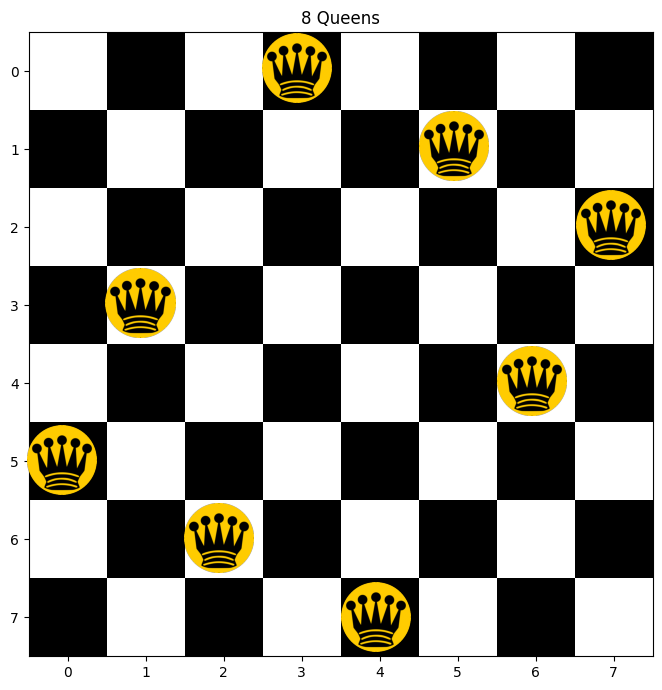

In [23]:
# Example of how to use this function
# plot_NQueens([4, 2, 0, 6, 1, 7, 5, 3])
# replace the parameter with your own results
plot_NQueens(solution)

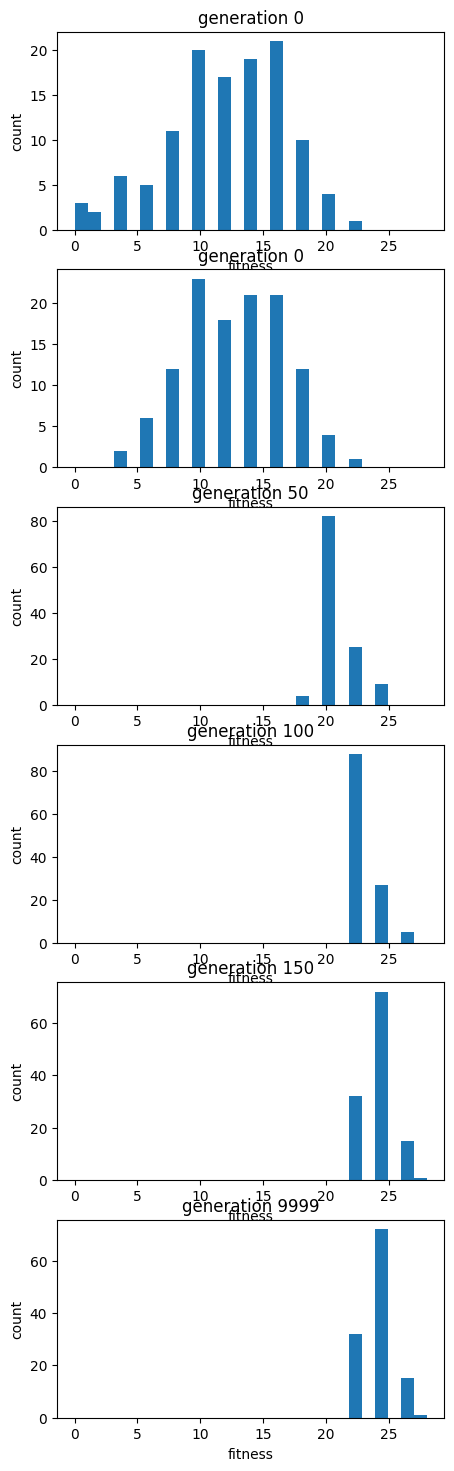

In [24]:
# Visualize the evolution of the polulation
bins = np.linspace(0, problem.max_fitness, problem.max_fitness)
plot_evolution(history, bins)